# Germinal center: chromatin based cell type detection: 
---
## Discrimination between 2 cell types


Data (from Claudio, IFOM): 
10 images depicting germinal centers (annotated by hand) stained for Dapi, CD3 and AICDA (dataset_1).

Aim: 
For cells within the germinal center use the nmco features to distinguish the following cell types:

1. AID+ dark zone B cells -> dark_b_cells
3. AID- light zone B cells  -> light_b_cells

In [1]:
# import libraries
import sys
sys.path.append("..")

from pathlib import Path
from glob import glob
import pandas as pd
import numpy as np
import os
from tqdm.notebook import tqdm
from sklearn.ensemble import RandomForestClassifier
import _pickle as cPickle
import matplotlib.pyplot as plt

from src.utils.cell_type_detection import get_postive_cells_batch
from src.utils.data_viz import plot_feature_space, vis_classes

from src.utils.data_processing import (
    clean_data,
    remove_correlated_features
)

from src.utils.data_processing import (
    clean_data,
    remove_correlated_features
)

from src.utils.discrimination import (
    compute_cv_scores,
    plot_cv_conf_mtx,
    plot_feature_importance, 
    find_markers, 
    plot_conf_mtx
)
from sklearn.metrics import confusion_matrix, classification_report
from tifffile import imread

seed = 1234

In [2]:
# read in the data
path_to_raw_images = '/media/pathy_s/54fe7289-2a61-4f3a-ac84-eeea3c0d1d2f/ifom_germinal_centers/dataset_1/' 
data_dir = path_to_raw_images + "consolidated_data/"

nuc_features = pd.read_csv(os.path.join(data_dir, "nuc_features.csv"), index_col=0)
spatial_cord = pd.read_csv(os.path.join(data_dir, "spatial_coordiates.csv"), index_col=0)
spatial_cord.index= spatial_cord['nuc_id']

aicda_levels = pd.read_csv(os.path.join(data_dir, "aicda_levels.csv"), index_col=0)
cd3_levels = pd.read_csv(os.path.join(data_dir, "cd3_levels.csv"), index_col=0)
gc_levels = pd.read_csv(os.path.join(data_dir, "gc_levels.csv"), index_col=0)

output_dir = '/media/pathy_s/54fe7289-2a61-4f3a-ac84-eeea3c0d1d2f/ifom_germinal_centers/code/analysis_resources/discriminating_2_celltypes/'
Path(output_dir).mkdir(parents=True, exist_ok=True)


## Assign cell types


In [3]:
# get postive cell ids
(_, fovs) = pd.factorize(gc_levels['image'].astype("category"))
img_names = fovs.categories

aicda_postive_cells = get_postive_cells_batch(aicda_levels, img_names)
gc_postive_cells = gc_levels[gc_levels['int_mean']>0]['nuc_id'].tolist()

nuc_features.loc[:,'aicda_status'] = 'negative'
nuc_features.loc[nuc_features['nuc_id'].isin(aicda_postive_cells), 'aicda_status'] ='positive'
nuc_features.loc[:,'gc_status'] = 'negative'
nuc_features.loc[nuc_features['nuc_id'].isin(gc_postive_cells), 'gc_status'] ='positive'

In [4]:
print ( "Number of cells :" + str(len(nuc_features['nuc_id'])))
print ( "Number of germinal center (gc) cells :" + str(len(gc_postive_cells)))

print ( "Number of acida positive cells :" + str(len(aicda_postive_cells)))
print ( "Number of acida positive cells in the gc :" + str(len(list(set(aicda_postive_cells) & set(gc_postive_cells)))))

print ( "Number of acida negative cells :" + str(len(list(set(nuc_features['nuc_id']) - set(aicda_postive_cells)))))
print ( "Number of acida negative cells in the gc:" + str(len(list((set(nuc_features['nuc_id']) - set(aicda_postive_cells)) & set(gc_postive_cells)))))

Number of cells :57179
Number of germinal center (gc) cells :25622
Number of acida positive cells :10676
Number of acida positive cells in the gc :8892
Number of acida negative cells :46503
Number of acida negative cells in the gc:16730


In [5]:
dark_b_cells = aicda_postive_cells
gc_dark_b_cells = list(set(dark_b_cells) & set(gc_postive_cells))

light_b_cells = list(set(nuc_features['nuc_id']) - set(aicda_postive_cells))
gc_light_b_cells = list((set(nuc_features['nuc_id']) - set(aicda_postive_cells)) & set(gc_postive_cells))

nuc_features.loc[:,'stage'] = 'none'
nuc_features.loc[nuc_features['nuc_id'].isin(gc_dark_b_cells), 'stage'] = 'dark_b_cells'
nuc_features.loc[nuc_features['nuc_id'].isin(gc_light_b_cells), 'stage'] = 'light_b_cells'

In [6]:
print ( "Number of dark b cells :" + str(len(dark_b_cells)))
print ( "Number of dark b cells in gc:" + str(len(gc_dark_b_cells)))

print ( "Number of light b cells :" + str(len(light_b_cells)))
print ( "Number of light b cells in gc:" + str(len(gc_light_b_cells)))

Number of dark b cells :10676
Number of dark b cells in gc:8892
Number of light b cells :46503
Number of light b cells in gc:16730


In [7]:
nuc_features.loc[:,'stage'] = 'none'
nuc_features.loc[nuc_features['nuc_id'].isin(gc_dark_b_cells), 'stage'] = 'dark_b_cells'
nuc_features.loc[nuc_features['nuc_id'].isin(gc_light_b_cells), 'stage'] = 'light_b_cells'

In [8]:
# subsapling cells in the germinal center
temp_db_cells = nuc_features.loc[nuc_features['stage'] == "dark_b_cells",]
temp_lb_cells = nuc_features.loc[nuc_features['stage'] == "light_b_cells",]

subsample_size = int(np.floor(0.8 * np.min([temp_db_cells.shape[0], temp_lb_cells.shape[0]])))
temp_db_cells = temp_db_cells.iloc[np.random.choice(len(temp_db_cells), size=subsample_size, replace=False)]
temp_lb_cells = temp_lb_cells.iloc[np.random.choice(len(temp_lb_cells), size=subsample_size, replace=False)]

training_data = pd.concat([temp_db_cells, temp_lb_cells])
training_data.loc[:,'split'] = "train"
training_data.index =  training_data.loc[:, 'nuc_id']

test_data = nuc_features.loc[~ nuc_features['nuc_id'].isin(training_data['nuc_id'])]
test_data = test_data[test_data.stage != 'none']
test_data.loc[:,'split'] = "test"
test_data.index =  test_data.loc[:, 'nuc_id']

gc_nuc_features = pd.concat([training_data, test_data])
gc_nuc_features.index =  gc_nuc_features.loc[:, 'nuc_id']
del temp_db_cells, temp_lb_cells

In [9]:
#save dataset
gc_nuc_features.to_csv(output_dir+"/" +"gc_nuc_features_with_cell_types.csv")
nuc_features.to_csv(output_dir+"/" +"nuc_features_with_cell_types.csv")


### Cleaning the dataset 

Next, we will ensure that all metadata columns are non-numeric. Then we remove highly correlated features and incomplete rows

In [10]:
# columns to remove
meta_columns = [
    "label",
    "weighted_centroid-0",
    "weighted_centroid-1",
    "centroid-0",
    "centroid-1",
    "bbox-0",
    "bbox-1",
    "bbox-2",
    "bbox-3",
    "nuc_id"
    "image",
    "orientation",
    "aicda_status",
    "cd3_status",
    "gc_status"
]

nuc_meta_columns = set(meta_columns).intersection(training_data.columns)
training_data.loc[:, nuc_meta_columns] = np.array(training_data.loc[:, nuc_meta_columns]).astype(
    "str"
)

In [11]:
set(meta_columns).intersection(training_data.columns)

{'aicda_status',
 'centroid-0',
 'centroid-1',
 'gc_status',
 'label',
 'orientation',
 'weighted_centroid-0',
 'weighted_centroid-1'}

In [12]:
training_data.index = training_data.nuc_id
cleaned_nuc_feat = clean_data(training_data, index_col="nuc_id")

Removed 19 constant or features with missing values. Remaining: 178.
Removed additional 0 features. Remaining: 178.
Removed 0 samples with missing values. Remaining: 14226.


In [13]:
filtered_nuc_feat = remove_correlated_features(cleaned_nuc_feat, 0.8)

Removed 115/178 features with a Pearson correlation above 0.8. Remaining: 63


In [14]:
sample_labels = training_data.loc[filtered_nuc_feat.index, "stage"]

In [15]:
# making sure that data is balanced
len(sample_labels[sample_labels =="dark_b_cells"]), len(sample_labels[sample_labels =="light_b_cells"])

(7113, 7113)

### Classification 

Next, we will train a RandomForest classifier to differentiate between the different stages.

In [16]:
# finding the optimal parameters for a random forest classifier
from sklearn.model_selection import GridSearchCV

rfc = RandomForestClassifier(random_state = seed,
                            class_weight = "balanced")

n_estimators = [100, 200, 300, 500, 800, 1000]
max_depth = [5, 8, 15, 20, 25, 30]
min_samples_split = [2, 5, 10, 15, 20,50,60,100]
min_samples_leaf = [1, 2, 5, 10] 

hyperF = dict(n_estimators = n_estimators, max_depth = max_depth,  
              min_samples_split = min_samples_split, 
             min_samples_leaf = min_samples_leaf)

gridF = GridSearchCV(rfc, hyperF, cv = 5, verbose = 1, 
                      n_jobs = 10)
bestF = gridF.fit(filtered_nuc_feat, sample_labels)

Fitting 5 folds for each of 1152 candidates, totalling 5760 fits


In [17]:
print(bestF.cv_results_['params'][bestF.best_index_])

{'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 20, 'n_estimators': 500}


In [18]:
print('The mean test score was {} with a standard deviation of {}'.format(bestF.cv_results_['mean_test_score'][bestF.best_index_],
             bestF.cv_results_['std_test_score'][bestF.best_index_]))

The mean test score was 0.6353154737571433 with a standard deviation of 0.008519454614784238


In [19]:
rfc = RandomForestClassifier(
    max_depth = bestF.cv_results_['params'][bestF.best_index_]['max_depth'],
    min_samples_leaf = bestF.cv_results_['params'][bestF.best_index_]['min_samples_leaf'],
    min_samples_split = bestF.cv_results_['params'][bestF.best_index_]['min_samples_split'],
    n_estimators = bestF.cv_results_['params'][bestF.best_index_]['n_estimators'],
    n_jobs=10, random_state=seed, class_weight="balanced", verbose=0
)
n_folds = 5

In [20]:
cv_scores = compute_cv_scores(
    X=filtered_nuc_feat,
    y=sample_labels,
    metrics=["accuracy", "balanced_accuracy", "f1_macro"],
    cv=n_folds,
    model=rfc,
)

In [21]:
cv_scores

,avg,std,min,max
accuracy,0.635315,0.008519,0.622496,0.646397
balanced_accuracy,0.635315,0.008515,0.622504,0.646388
f1_macro,0.635215,0.008532,0.622260,0.646164


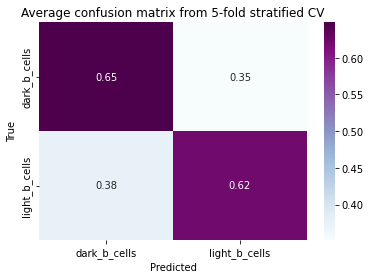

In [22]:
cplt = plot_cv_conf_mtx(
    X=filtered_nuc_feat,
    y=sample_labels,
    model=rfc,
    cv=n_folds,
    figsize=[6, 4],
)

In [23]:
## Fiting the model on the training data
fitted_rfc = rfc.fit(X=filtered_nuc_feat, y=sample_labels)
cPickle.dump(fitted_rfc,open( output_dir + 'rf_classifier', 'wb')) #save the classifier
## get prediction probabilities for each nucleus in the training dataset
pred = pd.DataFrame(fitted_rfc.predict(X=filtered_nuc_feat),
                    columns = ["predicted_class"],index=filtered_nuc_feat.index)
pred["actual_stage"] = sample_labels.astype(str)

pred_probs = pd.DataFrame(rfc.predict_proba(X=filtered_nuc_feat),
                          columns=["prob_" + x for x in list(rfc.classes_)],
                          index=filtered_nuc_feat.index,)
train_pred = pred.join(pred_probs)
train_pred['split'] = "train"

Now testing the performance on the test dataset

               dark_b_cells  light_b_cells
dark_b_cells           1185            594
light_b_cells          3836           5781
               precision    recall  f1-score   support

 dark_b_cells       0.24      0.67      0.35      1779
light_b_cells       0.91      0.60      0.72      9617

     accuracy                           0.61     11396
    macro avg       0.57      0.63      0.54     11396
 weighted avg       0.80      0.61      0.66     11396



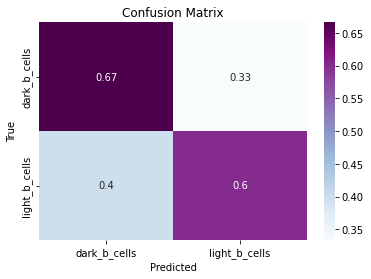

In [24]:
## get prediction probabilities for each nucleus
pred = pd.DataFrame(fitted_rfc.predict(X=test_data.loc[test_data.index, filtered_nuc_feat.columns]),
                    columns = ["predicted_class"],index=test_data.index)
pred["actual_stage"] =  test_data["stage"].astype(str)

pred_probs = pd.DataFrame(fitted_rfc.predict_proba(X=test_data.loc[test_data.index, filtered_nuc_feat.columns]),
                          columns=["prob_" + x for x in list(fitted_rfc.classes_)],
                          index=test_data.index)
test_pred = pred.join(pred_probs)
test_pred['split'] = "test"

## confusion matrix and perfromance metrics
conf_mtx = pd.DataFrame(confusion_matrix(test_pred["actual_stage"],
                                         test_pred["predicted_class"]), 
                    index=sorted(set(test_pred["actual_stage"])), 
                    columns=sorted(set(test_pred["actual_stage"])))
print(conf_mtx)

print(classification_report(test_pred["actual_stage"], 
                        test_pred["predicted_class"], 
                        target_names=sorted(set(test_pred["actual_stage"]))))

cplt = plot_conf_mtx(test_data.loc[:, filtered_nuc_feat.columns],
                    test_data["stage"].astype(str),
                    fitted_rfc,
                    normalize_matrix = "yes")   

In [25]:
# save the predictions
model_predictions = pd.concat([train_pred, test_pred])
model_predictions.to_csv(os.path.join( output_dir ,"model_predictions.csv"))

### Feature importance
Next we are interested in the features that yield the most discriminative power. To this end, we first look at the top 20 features that got the highest importance as computed by the RFC.

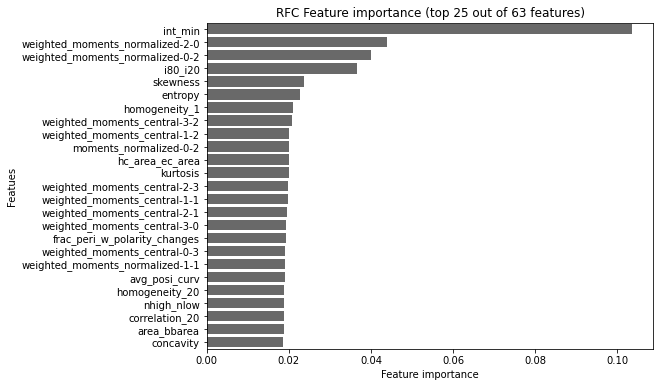

In [26]:
plot_feature_importance(
    importance=rfc.feature_importances_,
    names=filtered_nuc_feat.columns,
    model_type="RFC ",
    n_features=25
)

feat_import = pd.DataFrame(list(zip(training_data.columns, rfc.feature_importances_)),
                           columns=['feature','importance'])
feat_import.to_csv(os.path.join(output_dir ,"feature_importance.csv"))


As described earlier, we will additionally run a t-test based marker screen to identify the features that are the most different across the different stages.

In [27]:
marker_screen_results = find_markers(data=filtered_nuc_feat, labels=sample_labels)
marker_screen_results.to_csv(os.path.join( output_dir ,"marker_screen.csv"))

Run marker screen: 100%|██████████| 2/2 [00:00<00:00,  7.43it/s]


In [28]:
marker_screen_results.sort_values("fwer_padj").head(20)


,label,marker,fc,abs_delta_fc,pval,fwer_padj
13,dark_b_cells,int_min,1.173362,0.173362,4.265344e-147,5.374333e-145
13,light_b_cells,int_min,0.852252,0.147748,4.265344e-147,5.374333e-145
29,light_b_cells,weighted_moments_normalized-2-2,1.388079,0.388079,2.436381e-79,3.069840e-77
29,dark_b_cells,weighted_moments_normalized-2-2,0.720420,0.279580,2.436381e-79,3.069840e-77
27,dark_b_cells,weighted_moments_normalized-2-0,0.867425,0.132575,3.481434e-72,4.386606e-70
27,light_b_cells,weighted_moments_normalized-2-0,1.152837,0.152837,3.481434e-72,4.386606e-70
23,dark_b_cells,weighted_moments_normalized-0-2,0.871527,0.128473,1.630291e-65,2.054167e-63
23,light_b_cells,weighted_moments_normalized-0-2,1.147411,0.147411,1.630291e-65,2.054167e-63
17,dark_b_cells,i80_i20,0.975273,0.024727,1.123343e-44,1.415413e-42
17,light_b_cells,i80_i20,1.025353,0.025353,1.123343e-44,1.415413e-42


### Visualization

#### Reduced feature space
We now visualise the cells in the reduced feature space of the top 20 nmco features

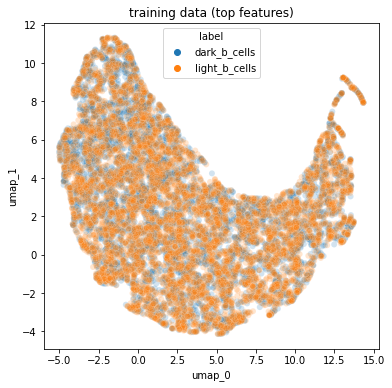

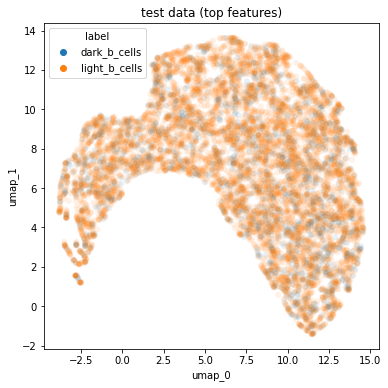

In [29]:
imp_features = feat_import[1:20].feature.tolist()

umpa_cord = plot_feature_space(data = gc_nuc_features.loc[training_data.index, imp_features],
                             labels = gc_nuc_features.loc[training_data.index, "stage"],
                             mode="umap",
                             figsize=[6, 6],
                             title="training data (top features)",
                             alpha=0.2)
umpb_cord = plot_feature_space(data = gc_nuc_features.loc[test_data.index, imp_features],
                             labels = gc_nuc_features.loc[test_data.index, "stage"],
                             mode="umap",
                             figsize=[6, 6],
                             title="test data (top features)",
                             alpha=0.1)

#### Prediction performance
We now plot the actual class vs predicted class in spatial cordinates for each image

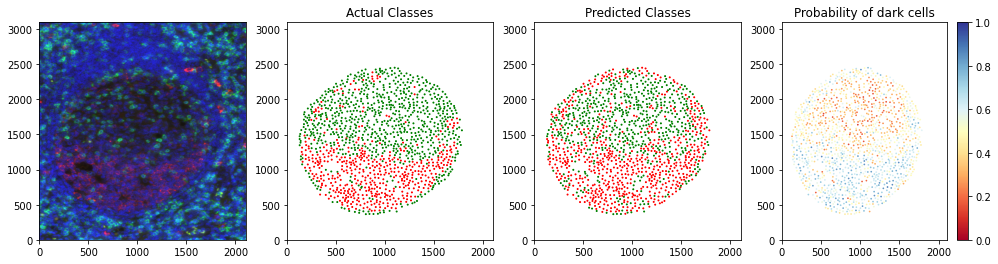

In [43]:
image_id = 5
img_path = os.path.join(os.path.join(path_to_raw_images,"images"),str(image_id)+".tif")
image = imread(img_path)
colors = {'dark_b_cells':'red', 'light_b_cells':'green', 't_cells':'blue', 'none': 'yellow'}
grouped = gc_nuc_features.groupby(gc_nuc_features.image)
data = grouped.get_group(image_id)
x = spatial_cord.loc[data.index,'centroid-0']
y = spatial_cord.loc[data.index,'centroid-1']
pred_labels = model_predictions.loc[data.index,"predicted_class"]
act_labels = model_predictions.loc[data.index,"actual_stage"]
fig = plt.figure(figsize=(17, 4))
ax0 = fig.add_subplot(141)
ax1 = fig.add_subplot(142)
ax2 = fig.add_subplot(143)
ax3 = fig.add_subplot(144)

ax0.imshow(image,aspect='auto', origin = 'lower' ) 
ax1.scatter(y,x, c=(act_labels.map(colors)),s=1)
ax1.set_title('Actual Classes')
ax1.set_ylim(0,image.shape[0])
ax1.set_xlim(0,image.shape[1])
   
ax2.scatter(y,x, c=(pred_labels.map(colors)),s=1)
ax2.set_title('Predicted Classes')
ax2.set_xlim(0,image.shape[1])
ax2.set_ylim(0,image.shape[0])

img = ax3.scatter(y,x, c=(model_predictions.loc[data.index,"prob_dark_b_cells"]),
                     s=0.5,cmap='RdYlBu',
                    vmin=0, vmax=1)
ax3.set_title('Probability of dark cells')
ax3.set_xlim(0,image.shape[1])
ax3.set_ylim(0,image.shape[0])
plt.colorbar(img)


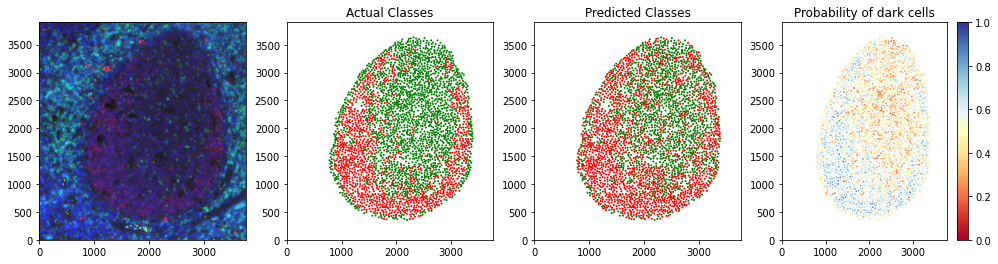

In [44]:
image_id = 3
img_path = os.path.join(os.path.join(path_to_raw_images,"images"),str(image_id)+".tif")
image = imread(img_path)
colors = {'dark_b_cells':'red', 'light_b_cells':'green', 't_cells':'blue', 'none': 'yellow'}
grouped = gc_nuc_features.groupby(gc_nuc_features.image)
data = grouped.get_group(image_id)
x = spatial_cord.loc[data.index,'centroid-0']
y = spatial_cord.loc[data.index,'centroid-1']
pred_labels = model_predictions.loc[data.index,"predicted_class"]
act_labels = model_predictions.loc[data.index,"actual_stage"]
fig = plt.figure(figsize=(17, 4))
ax0 = fig.add_subplot(141)
ax1 = fig.add_subplot(142)
ax2 = fig.add_subplot(143)
ax3 = fig.add_subplot(144)

ax0.imshow(image,aspect='auto', origin = 'lower' ) 
ax1.scatter(y,x, c=(act_labels.map(colors)),s=1)
ax1.set_title('Actual Classes')
ax1.set_ylim(0,image.shape[0])
ax1.set_xlim(0,image.shape[1])
   
ax2.scatter(y,x, c=(pred_labels.map(colors)),s=1)
ax2.set_title('Predicted Classes')
ax2.set_xlim(0,image.shape[1])
ax2.set_ylim(0,image.shape[0])

img = ax3.scatter(y,x, c=(model_predictions.loc[data.index,"prob_dark_b_cells"]),
                     s=0.5,cmap='RdYlBu',
                    vmin=0, vmax=1)
ax3.set_title('Probability of dark cells')
ax3.set_xlim(0,image.shape[1])
ax3.set_ylim(0,image.shape[0])
plt.colorbar(img)
